# 线性回归的从零开始实现(Pytorch)

In [1]:
import random
import torch
from d2l import torch as d2l

In [22]:
def synthetic_data(w, b, num_examples):
    # 正态分布生成X数据集
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    # 给y加上噪音
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))
    
# w = torch.tensor([2, -3.4])
# print(w.shape)
# X = torch.normal(0, 1, (num_examples, len(w)))
# print(X.shape)
# y = torch.mv(X, w) + 4.2
# y

In [49]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2

features, labels = synthetic_data(true_w, true_b, 1000)

print(f'features: {features[0]}, label: {labels[0]}')

features: tensor([0.2172, 1.9924]), label: tensor([-2.1522])


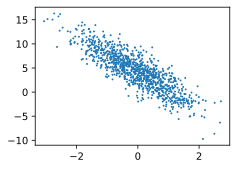

In [50]:
d2l.set_figsize()
# scatter分散, detach分离（不跟踪梯度）
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1) # 这个1是点的大小

In [51]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # shuffle洗牌, 打乱索引
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [52]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X)
    print(y)
    break

tensor([[ 0.0216,  1.2150],
        [-1.3052,  0.0406],
        [-1.0291, -0.0668],
        [-1.0435,  0.2577],
        [-0.0942,  0.5137],
        [ 1.7537, -1.1256],
        [ 0.0030,  0.0602],
        [-0.6461,  1.1867],
        [ 1.5803,  0.5952],
        [-2.2640, -1.0442]])
tensor([[ 0.1214],
        [ 1.4561],
        [ 2.3628],
        [ 1.2396],
        [ 2.2668],
        [11.5179],
        [ 4.0126],
        [-1.1152],
        [ 5.3320],
        [ 3.2333]])


In [54]:
# 迭代器案例
def my_iter(num):
    for i in range(num):
        yield i
        
for i in my_iter(5):
    print(i)

<generator object my_iter at 0x7faeb5f6cad0>
<generator object my_iter at 0x7faeb5f6cad0>


In [59]:
# 定义模型
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [57]:
# 定义损失函数
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [58]:
"""小批量随机梯度下降（Stochastic Gradient Descent, SGD）"""
def sgd(params, lr, batch_size):
    # 暂时禁用 PyTorch 的梯度计算。在更新参数时，不跟踪梯度
    with torch.no_grad():
        for param in params:
            # 向损失减少的方向根据学习率lr进行更新，batch_size 用于标准化梯度（因为梯度是在整个小批量上计算的）
            param -= lr * param.grad / batch_size
            param.grad.zero_() # 梯度清零

In [61]:
"""开始训练"""
# 设置超参数
lr = 0.03 # 学习率
num_epochs = 3 # 迭代周期

net = linreg # 线性回归模型
loss = squared_loss # 均方损失函数

# 初始化权重和偏置，并设置为需要计算梯度
w = torch.normal(0, 0.01, (2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)


for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

print(f'拟合的w: {w}, b: {b}')


epoch 1, loss 0.026540
epoch 2, loss 0.000087
epoch 3, loss 0.000048
拟合的w: tensor([[ 1.9993],
        [-3.3991]], requires_grad=True), b: tensor([4.1997], requires_grad=True)
